In [1]:
import glob
import numpy as np

# cognac data and tools
import cognac.insitu as iu

---
## load and select data

gps files may have to be edited manually 

In [3]:
# select campaign

#campaign = 'microco_leg2'
#campaign = 'lopstech19_leg1'
campaign = 'cognac20'

cp = iu.campaign(campaign)

In [3]:
# data directory and filename

unit = 'recepteur0'
unit = 'recepteur1' # j1 is bad
unit = 'recepteur2'

flag_iridium = False

In [4]:
# path may be a list now
upath = cp[unit]['path']
if isinstance(upath, str):
    data_dir = [upath+'gps/']
else:
    data_dir = [p+'gps/' for p in upath]
gps_files = [sorted(glob.glob(_dir+'GPS_*.log')) for _dir in data_dir]
gps_files = [item for sublist in gps_files for item in sublist]

# exclude cleaned up files
gps_files = [g for g in gps_files if 'nettoye' not in g]

# only consider cleaned up files
#gps_files = [g for g in gps_files if 'nettoye' in g]

gps_all = iu.gps.read_gps_lops(gps_files, label=unit, verbose=False)

# manually get rid of bad data points
gps_all.d = gps_all.d[gps_all.d['lon']!=0.]

Reads /Users/aponte/Current_projects/cognac/campagnes/2020_cognac20/data/recepteur2/gps/GPS_20201123113231.log
Reads /Users/aponte/Current_projects/cognac/campagnes/2020_cognac20/data/recepteur2/gps/GPS_20201124110434.log


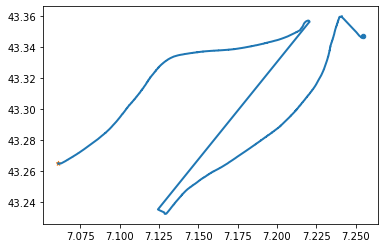

In [5]:
gps_all.plot()

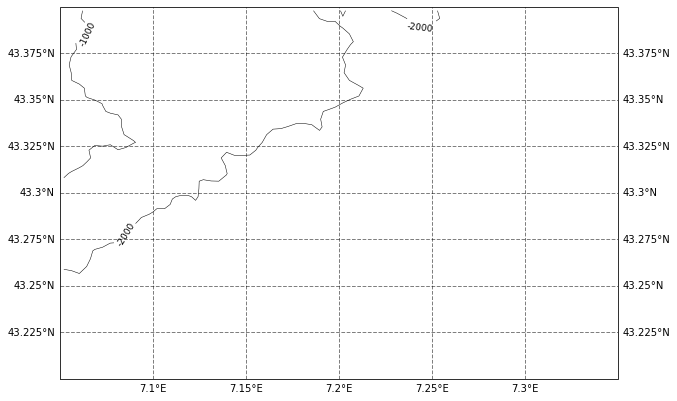

In [6]:
fac = cp.plot_map(coast='110m')
#gps_all.plot(fac)

In [7]:
gps_all.plot_bk(unit=cp[unit], rule='1T')

Loading BokehJS ...

---
## trim data

Look at acoustic data in order to choose time of deployment and recovery

In [8]:
#
# clean gps data with deployment log
gps={}
for r in cp[unit]:
    gps[r.label] = gps_all.clean(r, inplace=False)

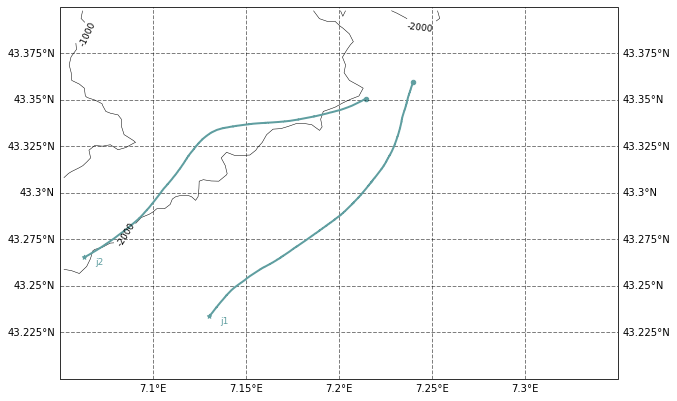

In [9]:
# plot overview map
fac = cp.plot_map(coast='110m')
for label, lgps in gps.items():
    if lgps:
        lgps.plot(fac, label=label, color=cp[unit]['color'])

In [10]:
gps

{'j1': cognac.insitu.gps.gps(recepteur2 - 72931 points),
 'j2': cognac.insitu.gps.gps(recepteur2 - 76501 points)}

In [11]:
gps['j1'].plot_bk(unit=cp[unit], rule='1T')

Loading BokehJS ...

--- 
## store

In [12]:
for label, lgps in gps.items():
    if lgps:
        lgps.to_nc(cp.pathp+unit+'_gps_'+label+'.nc')

Data store to /Users/aponte/Current_projects/cognac/campagnes/2020_cognac20/data/datap/recepteur2_gps_j1.nc
Data store to /Users/aponte/Current_projects/cognac/campagnes/2020_cognac20/data/datap/recepteur2_gps_j2.nc


### read

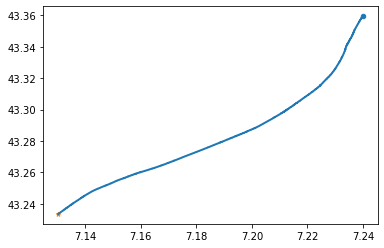

In [13]:
# reload
gps = cp.load('gps', unit=unit)[unit]
gps['j1'].plot()

---

## load all gps tracks and plot start/end positions

The goal is to adjust the yaml file positions with gps data

In [4]:
gps = cp.load('gps')
gps

{'recepteur1': {'j2': cognac.insitu.gps.gps(recepteur1 - 59411 points),
  'j1': cognac.insitu.gps.gps(recepteur1 - 5950 points)},
 'recepteur2': {'j1': cognac.insitu.gps.gps(recepteur2 - 72931 points),
  'j2': cognac.insitu.gps.gps(recepteur2 - 76501 points)},
 'emetteur': {'j1': cognac.insitu.gps.gps(source - 71291 points),
  'j2': cognac.insitu.gps.gps(source - 69770 points)},
 'recepteur0': {'j2': cognac.insitu.gps.gps(recepteur0 - 68899 points),
  'j1': cognac.insitu.gps.gps(recepteur0 - 74239 points)}}

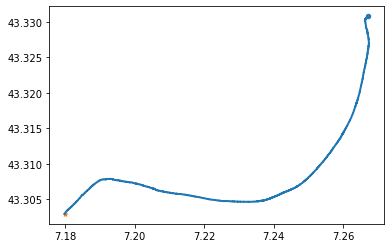

In [6]:
gps["recepteur0"]['j1'].plot()

In [7]:
gps["recepteur0"]['j1'].d

,lat,lon,velocity
time,,,
2020-11-23 10:46:01,43.330767,7.267145,0.164484
2020-11-23 10:46:02,43.330768,7.267140,0.445426
2020-11-23 10:46:03,43.330768,7.267138,0.134301
2020-11-23 10:46:04,43.330770,7.267137,0.232616
2020-11-23 10:46:05,43.330770,7.267135,0.134301
...,...,...,...
2020-11-24 07:24:16,43.302960,7.179880,0.000000
2020-11-24 07:24:17,43.302958,7.179882,0.232616
2020-11-24 07:24:18,43.302955,7.179885,0.455437


In [5]:
fmt = '%Y-%m-%d %H:%H:%S'

for uname, u in cp.items():
    print(uname)
    if uname in gps:
        for d in u:
            if d.label in gps[uname]:
                df = gps[uname][d.label].d.dropna(subset=['lon', 'lat'])
                #_gps.index.get_loc()
                istart = df.index.get_loc(d.start.time, method='nearest')
                iend = df.index.get_loc(d.end.time, method='nearest')
                print('  {}'.format(d.label))
                for e, v in dict(start=df.iloc[istart], end=df.iloc[iend]).items():
                    print('    {} (yaml): {} '.format(e, getattr(d, e).time.strftime(fmt)))                    
                    lon = iu.utils.dec2degmin(v['lon'])
                    lat = iu.utils.dec2degmin(v['lat'])
                    print('    {} (gps): {} lon/lat = {:} {:.2f} {} {:.2f}'.format(e, v.name.strftime(fmt), 
                                                                                   int(lon[0]), lon[1], lat[0], int(lat[1])
                                                                                  )
                         )
            else:
                print('{} - No gps for deployment {}'.format(uname, d.label))

mvp
emetteur
emetteur - No gps for deployment j1_synchro0
emetteur - No gps for deployment j1_synchro1
emetteur - No gps for deployment j1_synchro2
  j1
    start (yaml): 2020-11-23 12:12:33 
    start (gps): 2020-11-23 12:12:34 lon/lat = 7 13.71 43 22.00
    end (yaml): 2020-11-24 08:08:44 
    end (gps): 2020-11-24 08:08:44 lon/lat = 7 6.45 43 14.00
  j2
    start (yaml): 2020-11-24 13:13:38 
    start (gps): 2020-11-24 13:13:39 lon/lat = 7 11.35 43 19.00
    end (yaml): 2020-11-25 09:09:28 
    end (gps): 2020-11-25 09:09:28 lon/lat = 7 4.70 43 15.00
recepteur0
  j1
    start (yaml): 2020-11-23 10:10:00 
    start (gps): 2020-11-23 10:10:01 lon/lat = 7 16.03 43 19.00
    end (yaml): 2020-11-24 07:07:20 
    end (gps): 2020-11-24 07:07:20 lon/lat = 7 10.79 43 18.00
  j2
    start (yaml): 2020-11-24 12:12:40 
    start (gps): 2020-11-24 12:12:41 lon/lat = 7 7.89 43 19.00
    end (yaml): 2020-11-25 07:07:00 
    end (gps): 2020-11-25 07:07:00 lon/lat = 7 1.13 43 12.00
recepteur0 - No g